# 📘 Análise de Campanha de Cupons – Case iFood

Este notebook analisa os resultados de uma campanha de cupons promovida pelo iFood por meio de um teste A/B, com foco em:

- Avaliar impacto no ticket médio e retenção
- Identificar perfis comportamentais via segmentação
- Gerar recomendações estratégicas para o negócio

In [4]:
# Criar diretório para armazenar a amostra
if not os.path.exists("dados"):
    os.makedirs("dados")

# Amostrar 300.000 linhas do JSON original
with gzip.open("/content/order.json.gz", "rt", encoding="utf-8") as fin, gzip.open("dados/order_amostra.json.gz", "wt", encoding="utf-8") as fout:
    for i, linha in enumerate(fin):
        if i >= 300000:
            break
        fout.write(linha)

print("✅ Amostra criada com sucesso!")


✅ Amostra criada com sucesso!


In [5]:
# Pedidos
with gzip.open("dados/order_amostra.json.gz", "rt", encoding="utf-8") as f:
    pedidos = [json.loads(linha) for linha in f]
df_orders = pd.DataFrame(pedidos)

# Consumidores
df_consumers = pd.read_csv("/content/consumer.csv.gz")

# Restaurantes (opcional, não usado por enquanto)
df_restaurants = pd.read_csv("/content/restaurant.csv.gz")

# Teste A/B
df_ab = pd.read_csv("/content/ab_test_ref.csv", encoding='latin1')

# Verificar e renomear coluna se necessário
if "customer_id" not in df_ab.columns:
    df_ab.columns = ['customer_id', 'is_target']

# Unir dados
df_usuarios = pd.merge(df_consumers, df_ab, on="customer_id", how="inner")
df = pd.merge(df_orders, df_usuarios, on="customer_id", how="inner")

# Converter datas
df["order_created_at"] = pd.to_datetime(df["order_created_at"], errors="coerce")

# Criar coluna de retenção
df["retido"] = df.groupby("customer_id")["order_id"].transform("count") > 1

print("✅ Dados integrados e prontos para análise!")


✅ Dados integrados e prontos para análise!


In [6]:
# Agregar por usuário
usuarios = df.groupby(['customer_id', 'is_target']).agg({
    'order_id': 'count',
    'order_total_amount': 'mean',
    'retido': 'first'
}).reset_index().rename(columns={
    'order_id': 'n_pedidos',
    'order_total_amount': 'ticket_medio'
})

# Separar grupos
controle = usuarios[usuarios['is_target'] == 'control']
cuponado = usuarios[usuarios['is_target'] == 'target']

# Teste t para comparar ticket médio
stat, pval = ttest_ind(controle['ticket_medio'], cuponado['ticket_medio'], nan_policy='omit')
print(f"📌 p-valor do teste A/B para ticket médio: {pval:.4f}")


📌 p-valor do teste A/B para ticket médio: 0.7083


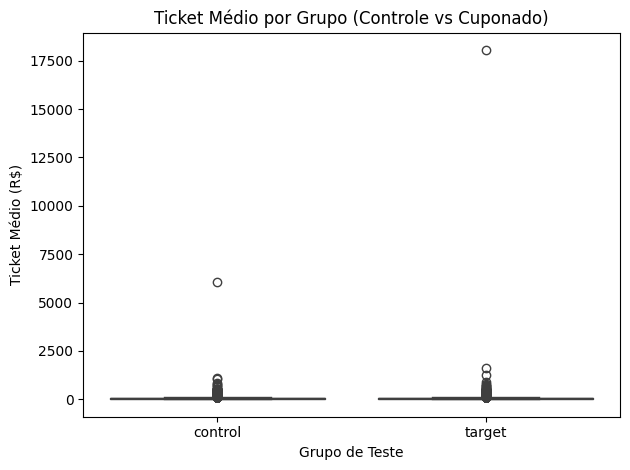

In [7]:
sns.boxplot(x='is_target', y='ticket_medio', data=usuarios)
plt.title("Ticket Médio por Grupo (Controle vs Cuponado)")
plt.xlabel("Grupo de Teste")
plt.ylabel("Ticket Médio (R$)")
plt.tight_layout()

# Salvar gráfico
plt.savefig("imagens/ticket_medio_por_grupo.png", dpi=300, bbox_inches='tight')
plt.show()


In [8]:
retencao = df.groupby("is_target")["retido"].mean().reset_index()
retencao.columns = ["Grupo", "Taxa de Retenção"]
retencao["Taxa de Retenção (%)"] = (retencao["Taxa de Retenção"] * 100).round(2)

print(retencao)


     Grupo  Taxa de Retenção  Taxa de Retenção (%)
0  control           0.44143                 44.14
1   target           0.46699                 46.70


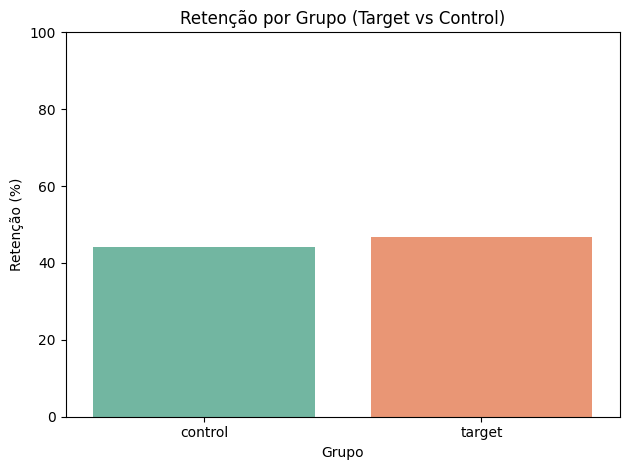

In [9]:
sns.barplot(data=retencao, x="Grupo", y="Taxa de Retenção (%)", hue="Grupo", palette="Set2", legend=False)
plt.title("Retenção por Grupo (Target vs Control)")
plt.ylabel("Retenção (%)")
plt.ylim(0, 100)
plt.tight_layout()

# Salvar gráfico
plt.savefig("imagens/retencao_por_grupo.png", dpi=300, bbox_inches='tight')
plt.show()


In [10]:
# Selecionar variáveis para clusterização
cluster_df = usuarios[["n_pedidos", "ticket_medio"]].copy()

# Padronizar os dados
scaler = StandardScaler()
X = scaler.fit_transform(cluster_df)

# Aplicar KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_df["cluster"] = kmeans.fit_predict(X)

# Adicionar rótulos ao dataset original
usuarios["cluster"] = cluster_df["cluster"]


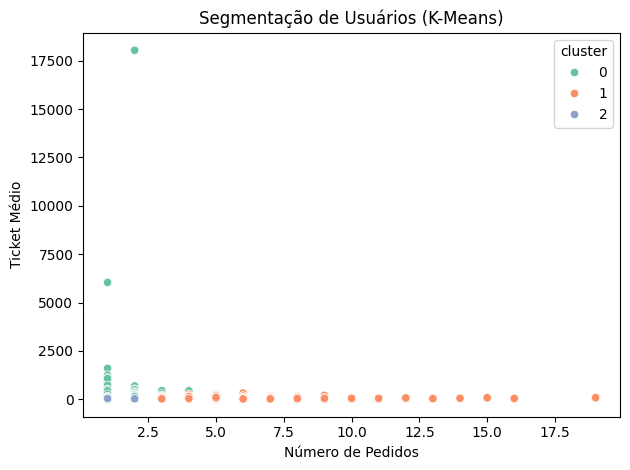

In [11]:
sns.scatterplot(data=usuarios, x="n_pedidos", y="ticket_medio", hue="cluster", palette="Set2")
plt.title("Segmentação de Usuários (K-Means)")
plt.xlabel("Número de Pedidos")
plt.ylabel("Ticket Médio")
plt.tight_layout()

# Salvar gráfico
plt.savefig("imagens/segmentacao_kmeans_scatter.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
usuarios.groupby("cluster")[["n_pedidos", "ticket_medio"]].mean().round(2)


,n_pedidos,ticket_medio
cluster,,
0,1.17,115.28
1,3.70,46.73
2,1.18,38.77


In [2]:
import os
import urllib.request
import gzip
import json
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Criar pasta para salvar os gráficos
if not os.path.exists("imagens"):
    os.makedirs("imagens")


In [3]:
# URLs fornecidas
urls = {
    "order.json.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz",
    "consumer.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz",
    "restaurant.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz",
    "ab_test.tar.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"
}

# Baixar arquivos
for nome_arquivo, url in urls.items():
    print(f"⬇️ Baixando {nome_arquivo}...")
    urllib.request.urlretrieve(url, f"/content/{nome_arquivo}")

# Extrair arquivo tar.gz
with tarfile.open("/content/ab_test.tar.gz", "r:gz") as tar:
    tar.extractall(path="/content")


⬇️ Baixando order.json.gz...
⬇️ Baixando consumer.csv.gz...
⬇️ Baixando restaurant.csv.gz...
⬇️ Baixando ab_test.tar.gz...
